# Support Vector Machine
In this experiment, we use the Support Vector Machine (SVM) model to classify varieties of the Iris dataset.

In [125]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In order to access the dataset, you may download it from the following [link](https://gist.github.com/netj/8836201) or load it from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

In [126]:
df = pd.read_csv('Datasets/iris.csv')
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


For this experiment, we will only perform binary classification. Thus, we drop the Virginica class as we will only use the model to classify between the Setosa and Versicolor classes. Moreover, instead of assigning the classes to the values $\{0, 1\}$, we will classify them with the values $\{-1, 1\}$ since we are using SVM.

In [127]:
df = df.drop(range(100, 150)) # Drop Virginica Class
df.loc[df['variety'] == 'Setosa', 'variety'] = -1 # Setting Setosa class to -1
df.loc[df['variety'] == 'Versicolor', 'variety'] = 1 # Setting Versicolor class to 1
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


Now, we split the dataset into the train, test, and validation sets. For this experiment, we use the first 40 samples of each class as the train set, the next 9 samples of each class for the test set, and the last one sample of each class for the validation set.

In [128]:
x = torch.tensor(df.iloc[:,2:4].values, dtype=torch.float32)
x_train = torch.cat((x[:40], x[50:90]))
x_test = torch.cat((x[40:49], x[90:99]))
x_valid = torch.cat((x[49:50], x[99:]))

y = torch.tensor(df.iloc[:,4].values.astype(np.int32), dtype=torch.int32)
y_train = torch.cat((y[:40], y[50:90]))
y_test = torch.cat((y[40:49], y[90:99]))
y_valid = torch.cat((y[49:50], y[99:]))

We now construct the SVM model class. The following references [[1](https://www.youtube.com/watch?v=T9UcK-TxQGw), [2](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)] were used in the implementation of our model. The $f$ function returns the forward pass of our SVM model, which is just the linear function $f(x) = wX - b$. The $J$ function computes for the hinge loss, while the $update$ function updates the weight and bias terms of our model.

In [129]:
class SupportVectorMachine():
    def __init__(self, num_features=2, lr=0.001, lmbd=0.001, epochs=1500):
        self.lr = lr
        self.lmbd = lmbd
        self.epochs = epochs
        self.num_features = num_features
        self.w = torch.ones(self.num_features)
        self.b = 0.

    def f(self, x):
        return self.w @ x.T - self.b

    def J(self, x, y):
        n = len(list(y))
        costs = torch.zeros(n)
        costs = torch.column_stack((costs, 1-(y*self.f(x))))
        costs = torch.max(costs, dim=1).values
        return torch.sum(costs) / n

    def update(self, x, y):
        for i, class_val in enumerate(y):
            if class_val*self.f(x[i]) >= 1:
                self.w -= self.lr*2*self.lmbd*self.w
            else:
                self.w -= self.lr*(2*self.lmbd*self.w - class_val*x[i])
                self.b -= self.lr*class_val

    def fit(self, x, y):
        for epoch in range(self.epochs):
            self.lmbd = 1/(epoch+1)
            cost = self.J(x,y)
            if epoch % (self.epochs//10) == 0 or epoch == (self.epochs-1):
                print(f'Epoch {epoch} train loss: {cost}')
            self.update(x,y)

    def test(self, x, y, log=False):
        preds = self.predict(x)
        if log == True:
            for i, pred in enumerate(preds):
                print(f'Prediction: {pred} | Actual: {y[i]}')
        acc = (torch.sum((preds==y).float())/len(list(y))) * 100.
        print(f'\nTest accuracy: {acc}%')
        return acc
    
    def predict(self, x):
        return torch.sign(self.f(x)).int()

We now train and test our model. The train loss is printed at the first, last, and every $epochs//10$-th epoch. We observe that the train loss continues to decrease (which is a good sign) as we go through each epochs. Moreover, we observe that the model performs well in classifying the varieties of the Iris dataset, since it has a test accuracy of $100\%$.

In [130]:
if __name__ == '__main__':
    svm = SupportVectorMachine()
    svm.fit(x_train, y_train)
    def shuffle_data(x,i): return x[i].view(x.size())
    i = torch.randperm(x_test.shape[0])
    x_test = shuffle_data(x_test,i)
    y_test = shuffle_data(y_test,i)
    svm.test(x_test, y_test)

Epoch 0 train loss: 1.3475000858306885
Epoch 150 train loss: 0.020278073847293854
Epoch 300 train loss: 0.005584667436778545
Epoch 450 train loss: 0.003487189067527652
Epoch 600 train loss: 0.002347803208976984
Epoch 750 train loss: 0.001263260841369629
Epoch 900 train loss: 0.0009069055086001754
Epoch 1050 train loss: 0.0005172312376089394
Epoch 1200 train loss: 0.0002003997506108135
Epoch 1350 train loss: 0.0
Epoch 1499 train loss: 0.0

Test accuracy: 100.0%


Let us visualize our SVM model, along with the training and validation data. As observed, the decision boundary or the maximum margin hyperplane of the SVM model correctly divides the samples into their respective classes. Moreover, we also see that the support vectors lie on the negative and positive hyperplanes, which is good since we want to maximize the distance between the decision boundary and the closest data points.

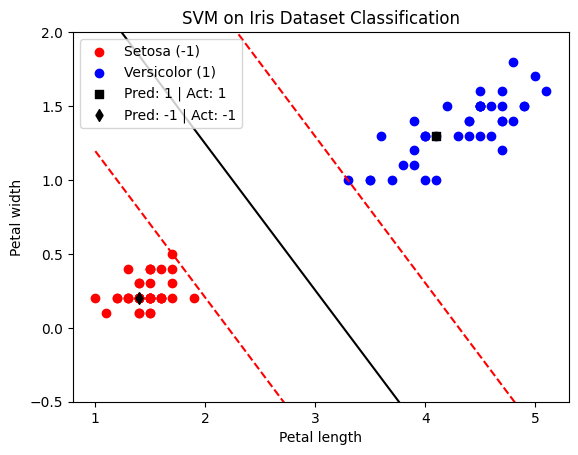

In [132]:
i = torch.randperm(x_valid.shape[0])
x_valid = shuffle_data(x_valid,i)
y_valid = shuffle_data(y_valid,i)

def hyperplane(x, w, b, off): return (-w[0]*x + b + off) / w[1]
plt.scatter(x_train[:40, 0], x_train[:40, 1], marker="o", c="red", label='Setosa (-1)')
plt.scatter(x_train[40:, 0], x_train[40:, 1], marker="o", c="blue", label='Versicolor (1)')
plt.scatter(x_valid[0, 0], x_valid[0, 1], marker="s", c="black", label=f'Pred: {svm.predict(x_valid[0])} | Act: {y_valid[0]}')
plt.scatter(x_valid[1, 0], x_valid[1, 1], marker="d", c="black", label=f'Pred: {svm.predict(x_valid[1])} | Act: {y_valid[1]}')

x01 = torch.min(x_train[:,0])
x02 = torch.max(x_train[:,0])
x11 = hyperplane(x01, svm.w, svm.b, 0)
x12 = hyperplane(x02, svm.w, svm.b, 0)
x11n = hyperplane(x01, svm.w, svm.b, -1)
x12n = hyperplane(x02, svm.w, svm.b, -1)
x11p = hyperplane(x01, svm.w, svm.b, 1)
x12p = hyperplane(x02, svm.w, svm.b, 1)

plt.plot([x01, x02], [x11, x12], 'k')
plt.plot([x01, x02], [x11n, x12n], 'r--')
plt.plot([x01, x02], [x11p, x12p], 'r--')
plt.ylim(-.5,2)
plt.ylabel('Petal width')
plt.xlabel('Petal length')
plt.title('SVM on Iris Dataset Classification')
plt.legend()
plt.show()